<a href="https://colab.research.google.com/github/xiaochengJF/MachineLearning/blob/master/Ex7_Kmeans_and_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd /content/drive/My Drive/MachineLearning/ex7-kmeans and PCA

/content/drive/My Drive/MachineLearning/ex7-kmeans and PCA


# 1-数据可视化

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.io as sio

# data1

In [4]:
mat = sio.loadmat('./data/ex7data1.mat')
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X'])

In [5]:
data1 = pd.DataFrame(mat.get('X'), columns=['X1', 'X2'])
data1.head()

,X1,X2
0,3.381563,3.389113
1,4.527875,5.854178
2,2.655682,4.411995
3,2.765235,3.715414
4,2.846560,4.175506


***

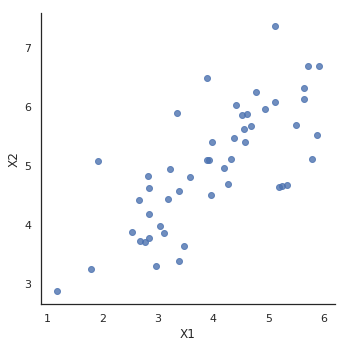

In [7]:
sns.set(context="notebook", style="white")
sns.lmplot('X1', 'X2', data=data1, fit_reg=False)
plt.show()

# data2

In [8]:
mat = sio.loadmat('./data/ex7data2.mat')
data2 = pd.DataFrame(mat.get('X'), columns=['X1', 'X2'])
data2.head()

,X1,X2
0,1.842080,4.607572
1,5.658583,4.799964
2,6.352579,3.290854
3,2.904017,4.612204
4,3.231979,4.939894


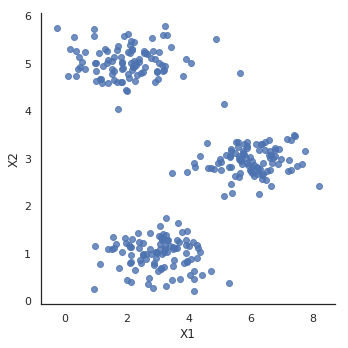

In [9]:
sns.lmplot('X1', 'X2', data=data2, fit_reg=False)
plt.show()


# 2-2维kmeans

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import scipy.io as sio

         X1        X2
0  1.842080  4.607572
1  5.658583  4.799964
2  6.352579  3.290854
3  2.904017  4.612204
4  3.231979  4.939894


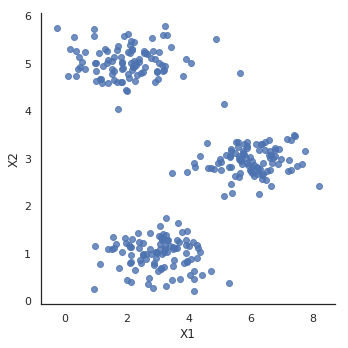

In [11]:
mat = sio.loadmat('./data/ex7data2.mat')
data2 = pd.DataFrame(mat.get('X'), columns=['X1', 'X2'])
print(data2.head())

sns.set(context="notebook", style="white")
sns.lmplot('X1', 'X2', data=data2, fit_reg=False)
plt.show()

## 随机初始化

In [0]:
def combine_data_C(data, C):
    data_with_c = data.copy()
    data_with_c['C'] = C
    return data_with_c

In [0]:
def random_init(data, k):
    """choose k sample from data set as init centroids
    Args:
        data: DataFrame
        k: int
    Returns:
        k samples: ndarray
    """
    return data.sample(k).as_matrix()

<font face=楷体 color=green size=4>**绿色链接：** </font>   
【1】[numpy.apply_along_axis](https://docs.scipy.org/doc/numpy/reference/generated/numpy.apply_along_axis.html)  
【2】[numpy.linalg.norm](https://het.as.utexas.edu/HET/Software/Numpy/reference/generated/numpy.linalg.norm.html)

In [0]:
def _find_your_cluster(x, centroids):
    """find the right cluster for x with respect to shortest distance
    Args:
        x: ndarray (n, ) -> n features
        centroids: ndarray (k, n)
    Returns:
        k: int
    """
    distances = np.apply_along_axis(func1d=np.linalg.norm,  # l2范数
                                    axis=1,
                                    arr=centroids - x)  # Input array.
    # 对tensor沿着axis应用函数 # use ndarray's broadcast
    return np.argmin(distances)

In [0]:
def assign_cluster(data, centroids):
    """assign cluster for each node in data
    return C ndarray
    """
    return np.apply_along_axis(lambda x: _find_your_cluster(x, centroids),
                               axis=1,
                               arr=data.as_matrix())

In [0]:
def new_centroids(data, C):
    data_with_c = combine_data_C(data, C)

    return data_with_c.groupby('C', as_index=False).\
                       mean().\
                       sort_values(by='C').\
                       drop('C', axis=1).\
                       as_matrix()

In [0]:
def cost(data, centroids, C):
    m = data.shape[0]

    expand_C_with_centroids = centroids[C]

    distances = np.apply_along_axis(func1d=np.linalg.norm,
                                    axis=1,
                                    arr=data.as_matrix() - expand_C_with_centroids)
    return distances.sum() / m

In [0]:
def _k_means_iter(data, k, epoch=100, tol=0.0001):
    """one shot k-means
    with early break
    """
    centroids = random_init(data, k)
    cost_progress = []

    for i in range(epoch):
        print('running epoch {}'.format(i))

        C = assign_cluster(data, centroids)
        centroids = new_centroids(data, C)
        cost_progress.append(cost(data, centroids, C))

        if len(cost_progress) > 1:  # early break
            if (np.abs(cost_progress[-1] - cost_progress[-2])) / cost_progress[-1] < tol:
                break

    return C, centroids, cost_progress[-1]

In [0]:
def k_means(data, k, epoch=100, n_init=10):
    """do multiple random init and pick the best one to return
    Args:
        data (pd.DataFrame)
    Returns:
        (C, centroids, least_cost)
    """

    tries = np.array([_k_means_iter(data, k, epoch) for _ in range(n_init)])

    least_cost_idx = np.argmin(tries[:, -1])

    return tries[least_cost_idx]

In [20]:
random_init(data2, 3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


array([[2.76494499, 1.43148951],
       [2.53446019, 1.21562081],
       [0.3639172 , 4.73332823]])

## 簇

In [21]:
init_centroids = random_init(data2, 3)
init_centroids

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


array([[7.21684033, 2.72896575],
       [3.91596068, 1.01225774],
       [1.84419981, 5.03153948]])

In [0]:
x = np.array([1, 1])

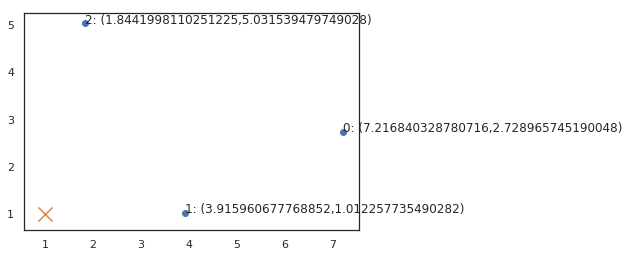

In [23]:
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(x=init_centroids[:, 0], y=init_centroids[:, 1])

for i, node in enumerate(init_centroids):
    ax.annotate('{}: ({},{})'.format(i, node[0], node[1]), node)
    
ax.scatter(x[0], x[1], marker='x', s=200)
plt.show()

In [24]:
_find_your_cluster(x, init_centroids)

1

## 簇分配

In [25]:
C = assign_cluster(data2, init_centroids)
data_with_c =combine_data_C(data2, C)
data_with_c.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


,X1,X2,C
0,1.842080,4.607572,2
1,5.658583,4.799964,0
2,6.352579,3.290854,0
3,2.904017,4.612204,2
4,3.231979,4.939894,2


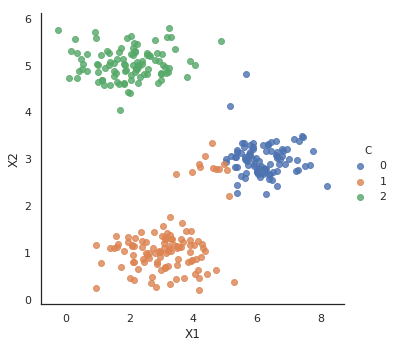

In [26]:
sns.lmplot('X1', 'X2', hue='C', data=data_with_c, fit_reg=False)
plt.show()

## 计算新的中心坐标

In [27]:
new_centroids(data2, C)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


array([[6.20016778, 2.99145411],
       [3.18855555, 1.17748437],
       [1.98363152, 5.03043004]])

In [0]:
final_C, final_centroid, _= _k_means_iter(data2, 3)
data_with_c = combine_data_C(data2, final_C)

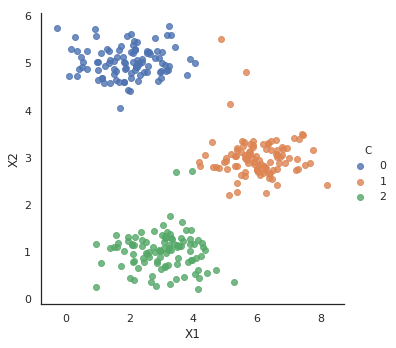

In [29]:
sns.lmplot('X1', 'X2', hue='C', data=data_with_c, fit_reg=False)
plt.show()

In [30]:
cost(data2, final_centroid, final_C)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


0.794176363371587

In [0]:
best_C, best_centroids, least_cost = k_means(data2, 3)

In [32]:
least_cost

0.794176363371587

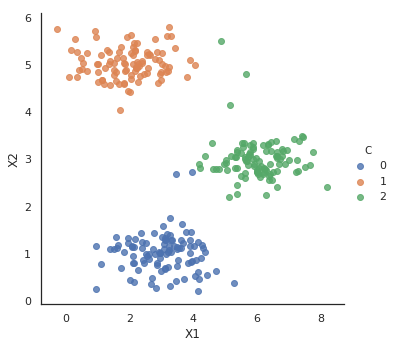

In [33]:
data_with_c = combine_data_C(data2, best_C)
sns.lmplot('X1', 'X2', hue='C', data=data_with_c, fit_reg=False)
plt.show()

## sklearn kmeans

In [0]:
from sklearn.cluster import KMeans

sk_kmeans = KMeans(n_clusters=3)
sk_kmeans.fit(data2)
sk_C = sk_kmeans.predict(data2)

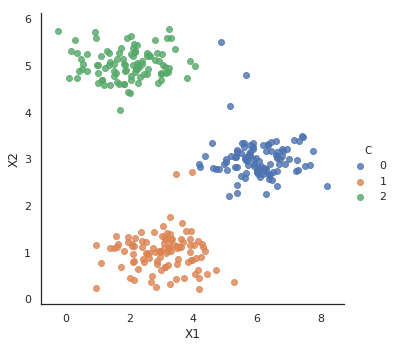

In [36]:
data_with_c = combine_data_C(data2, sk_C)
sns.lmplot('X1', 'X2', hue='C', data=data_with_c, fit_reg=False)
plt.show()

# 3- kmeans用于图像压缩

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

## 加载图像为ndarray

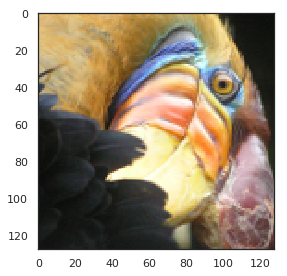

In [39]:
from skimage import io

# 强制转换为float，否则clustring之后的颜色会很奇怪
pic = io.imread('data/bird_small.png') / 255.
io.imshow(pic)

In [40]:
pic.shape

(128, 128, 3)

In [0]:
# serialize data
data = pic.reshape(128*128, 3)

## K-mean

In [0]:
def k_means(data, k, epoch=100, n_init=10):
    """do multiple random init and pick the best one to return
    Args:
        data (pd.DataFrame)
    Returns:
        (C, centroids, least_cost)
    """

    tries = np.array([_k_means_iter(data, k, epoch) for _ in range(n_init)])

    least_cost_idx = np.argmin(tries[:, -1])

    return tries[least_cost_idx]

# support fn --------------------------------
def combine_data_C(data, C):
    data_with_c = data.copy()
    data_with_c['C'] = C
    return data_with_c


# k-means fn --------------------------------
def random_init(data, k):
    """choose k sample from data set as init centroids
    Args:
        data: DataFrame
        k: int
    Returns:
        k samples: ndarray
    """
    return data.sample(k).as_matrix()


def _find_your_cluster(x, centroids):
    """find the right cluster for x with respect to shortest distance
    Args:
        x: ndarray (n, ) -> n features
        centroids: ndarray (k, n)
    Returns:
        k: int
    """
    distances = np.apply_along_axis(func1d=np.linalg.norm,  # this give you l2 norm
                                    axis=1,
                                    arr=centroids - x)  # use ndarray's broadcast
    return np.argmin(distances)


def assign_cluster(data, centroids):
    """assign cluster for each node in data
    return C ndarray
    """
    return np.apply_along_axis(lambda x: _find_your_cluster(x, centroids),
                               axis=1,
                               arr=data.as_matrix())


def new_centroids(data, C):
    data_with_c = combine_data_C(data, C)

    return data_with_c.groupby('C', as_index=False).\
                       mean().\
                       sort_values(by='C').\
                       drop('C', axis=1).\
                       as_matrix()


def cost(data, centroids, C):
    m = data.shape[0]

    expand_C_with_centroids = centroids[C]

    distances = np.apply_along_axis(func1d=np.linalg.norm,
                                    axis=1,
                                    arr=data.as_matrix() - expand_C_with_centroids)
    return distances.sum() / m


def _k_means_iter(data, k, epoch=100, tol=0.0001):
    """one shot k-means
    with early break
    """
    centroids = random_init(data, k)
    cost_progress = []

    for i in range(epoch):
        print('running epoch {}'.format(i))

        C = assign_cluster(data, centroids)
        centroids = new_centroids(data, C)
        cost_progress.append(cost(data, centroids, C))

        if len(cost_progress) > 1:  # early break
            if (np.abs(cost_progress[-1] - cost_progress[-2])) / cost_progress[-1] < tol:
                break

    return C, centroids, cost_progress[-1]

In [43]:
C, centroids, cost = k_means(pd.DataFrame(data), 16, epoch = 10, n_init=3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


running epoch 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


running epoch 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


running epoch 2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


running epoch 3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


running epoch 4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


running epoch 5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


running epoch 6


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


running epoch 7


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


running epoch 8


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


running epoch 9


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


running epoch 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


running epoch 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


running epoch 2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


running epoch 3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


running epoch 4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


running epoch 5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


running epoch 6


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


running epoch 7


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


running epoch 8


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


running epoch 9


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


running epoch 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


running epoch 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


running epoch 2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


running epoch 3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


running epoch 4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


running epoch 5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


running epoch 6


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


running epoch 7


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


running epoch 8


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


running epoch 9


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


## sklearn K-means

In [0]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=16, n_init=100, n_jobs=-1)

In [45]:
model.fit(data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=16, n_init=100, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [46]:
centroids = model.cluster_centers_
print(centroids.shape)

C = model.predict(data)
print(C.shape)

(16, 3)
(16384,)


In [47]:
centroids[C].shape

(16384, 3)

In [0]:
compressed_pic = centroids[C].reshape((128,128,3))

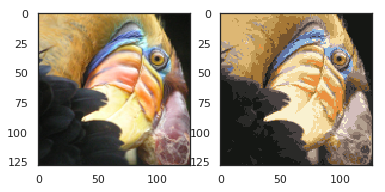

In [49]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(pic)
ax[1].imshow(compressed_pic)
plt.show()

# 4-二维PCA

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="notebook", style="white")

import numpy as np
import pandas as pd
import scipy.io as sio

## 加载数据

In [0]:
def get_X(df):
    """
    use concat to add intersect feature to avoid side effect
    not efficient for big dataset though
    """
    ones = pd.DataFrame({'ones': np.ones(len(df))})
    data = pd.concat([ones, df], axis=1)  # column concat
    return data.iloc[:, :-1].as_matrix()  # this return ndarray, not matrix


def get_y(df):
    '''assume the last column is the target'''
    return np.array(df.iloc[:, -1])


def normalize_feature(df):
    """Applies function along input axis(default 0) of DataFrame."""
    return df.apply(lambda column: (column - column.mean()) / column.std())

In [52]:

mat = sio.loadmat('./data/ex7data1.mat')
X = mat.get('X')

# visualize raw data
print(X.shape)

(50, 2)


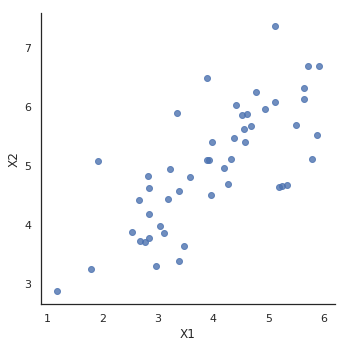

In [53]:
sns.lmplot('X1', 'X2', 
           data=pd.DataFrame(X, columns=['X1', 'X2']),
           fit_reg=False)
plt.show()

## 标准化数据

In [0]:
def plot_n_image(X, n):
    """ plot first n images
    n has to be a square number
    """
    pic_size = int(np.sqrt(X.shape[1]))
    grid_size = int(np.sqrt(n))

    first_n_images = X[:n, :]

    fig, ax_array = plt.subplots(nrows=grid_size, ncols=grid_size,
                                    sharey=True, sharex=True, figsize=(8, 8))

    for r in range(grid_size):
        for c in range(grid_size):
            ax_array[r, c].imshow(first_n_images[grid_size * r + c].reshape((pic_size, pic_size)))
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))

In [0]:
# 协方差
def covariance_matrix(X):
    """
    Args:
        X (ndarray) (m, n)
    Return:
        cov_mat (ndarray) (n, n):
            covariance matrix of X
    """
    m = X.shape[0]

    return (X.T @ X) / m


In [0]:
def normalize(X):
    """
        for each column, X-mean / std
    """
    X_copy = X.copy()
    m, n = X_copy.shape

    for col in range(n):
        X_copy[:, col] = (X_copy[:, col] - X_copy[:, col].mean()) / X_copy[:, col].std()

    return X_copy

<font face=楷体 color=green size=4>**绿色链接：**</font>  
【1】[numpy.linalg.svd](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html)

In [0]:
def pca(X):
    """
    Args:
        X ndarray(m, n)
    Returns:
        U ndarray(n, n): 主成分
    """
    # 1. 标准化数据
    X_norm = normalize(X)

    # 2. 计算协方差矩阵
    Sigma = covariance_matrix(X_norm)  # (n, n)

    # 3. 进行奇异值分解
    # cov矩阵是对称的
    # left sigular vector and right singular vector is the same, which means
    # U is V, so we could use either one to do dim reduction
    U, S, V = np.linalg.svd(Sigma)  # U: principle components (n, n)

    return U, S, V

In [0]:
# 将数据投影到更低维度
def project_data(X, U, k):
    """
    Args:
        U (ndarray) (n, n)
    Return:
        projected X (n dim) at k dim
    """
    m, n = X.shape

    if k > n:
        raise ValueError('k should be lower dimension of n')

    return X @ U[:, :k]


In [0]:
# 还原
def recover_data(Z, U):
    m, n = Z.shape

    if n >= U.shape[0]:
        raise ValueError('Z dimension is >= U, you should recover from lower dimension to higher')

    return Z @ U[:, :n].T

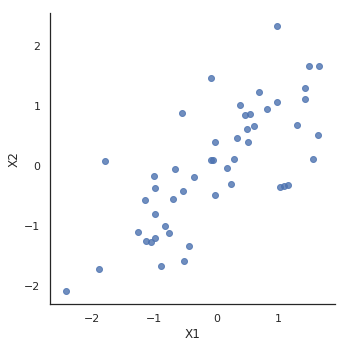

In [65]:
X_norm = normalize(X)

sns.lmplot('X1', 'X2', 
           data=pd.DataFrame(X_norm, columns=['X1', 'X2']),
           fit_reg=False)
plt.show()

## 协方差矩阵  
$$\sum=\frac1mX^TX$$  

<font face=楷体><font face=STCAIYUN color=red size=4>注意：</font>无偏估计是除以 $m-1$，因为差别不大，为简洁取$m$</font>

In [66]:
Sigma =covariance_matrix(X_norm)  # capital greek Sigma
Sigma  # (n, n)

array([[1.        , 0.73553038],
       [0.73553038, 1.        ]])

## PCA

In [67]:
U, S, V = pca(X_norm)
U

array([[-0.70710678, -0.70710678],
       [-0.70710678,  0.70710678]])

In [68]:
u1 = U[0]
u1

array([-0.70710678, -0.70710678])

## 投影数据到低维度

In [69]:
# show top 10 projected data
Z = project_data(X_norm, U, 1)
Z[:10]

array([[ 1.49631261],
       [-0.92218067],
       [ 1.22439232],
       [ 1.64386173],
       [ 1.2732206 ],
       [-0.97681976],
       [ 1.26881187],
       [-2.34148278],
       [-0.02999141],
       [-0.78171789]])

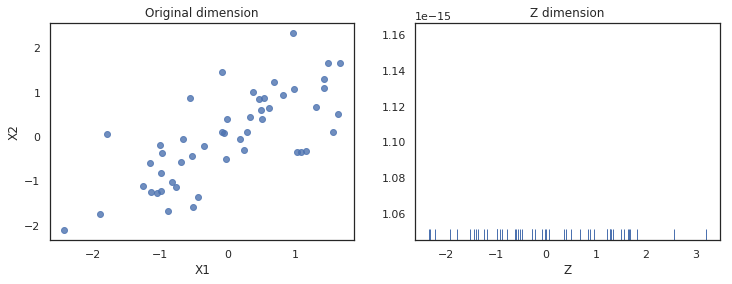

In [70]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))

sns.regplot('X1', 'X2', 
           data=pd.DataFrame(X_norm, columns=['X1', 'X2']),
           fit_reg=False,
           ax=ax1)
ax1.set_title('Original dimension')

sns.rugplot(Z, ax=ax2)
ax2.set_xlabel('Z')
ax2.set_title('Z dimension')
plt.show()

## 恢复数据  

<font face=楷体><font face=STCAIYUN color=red size=4>注意：</font>是弱还原，降维过程会丢失信息</font>  

<font face=楷体 color=green size=4>绿色链接：</font>  
【1】[使用matplotlib的界面进行seaborn绘图](https://stackoverflow.com/questions/23969619/plotting-with-seaborn-using-the-matplotlib-object-oriented-interface/23973562#23973562)

Text(0.5, 1.0, 'Original dimension')

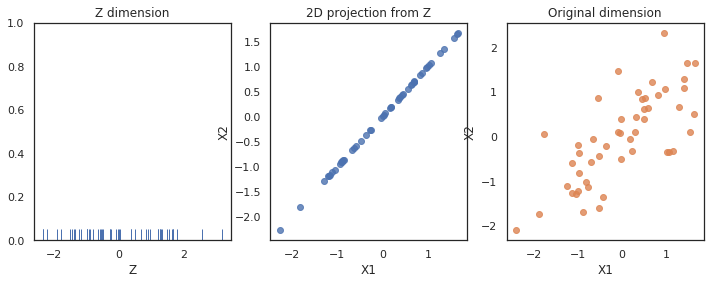

In [71]:
X_recover = recover_data(Z, U)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 4))

sns.rugplot(Z, ax=ax1)
ax1.set_title('Z dimension')
ax1.set_xlabel('Z')

sns.regplot('X1', 'X2', 
           data=pd.DataFrame(X_recover, columns=['X1', 'X2']),
           fit_reg=False,
           ax=ax2)
ax2.set_title("2D projection from Z")

sns.regplot('X1', 'X2', 
           data=pd.DataFrame(X_norm, columns=['X1', 'X2']),
           fit_reg=False,
           ax=ax3)
ax3.set_title('Original dimension')


# 5-PCA用于面部数据

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="notebook", style="white")

import numpy as np
import pandas as pd
import scipy.io as sio

In [73]:
mat = sio.loadmat('./data/ex7faces.mat')
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X'])

In [74]:
X = np.array([x.reshape((32, 32)).T.reshape(1024) for x in mat.get('X')])
X.shape

(5000, 1024)

In [0]:
# support functions ---------------------------------------
def plot_n_image(X, n):
    """ plot first n images
    n has to be a square number
    """
    pic_size = int(np.sqrt(X.shape[1]))
    grid_size = int(np.sqrt(n))

    first_n_images = X[:n, :]

    fig, ax_array = plt.subplots(nrows=grid_size, ncols=grid_size,
                                    sharey=True, sharex=True, figsize=(8, 8))

    for r in range(grid_size):
        for c in range(grid_size):
            ax_array[r, c].imshow(first_n_images[grid_size * r + c].reshape((pic_size, pic_size)))
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))


# PCA functions ---------------------------------------
def covariance_matrix(X):
    """
    Args:
        X (ndarray) (m, n)
    Return:
        cov_mat (ndarray) (n, n):
            covariance matrix of X
    """
    m = X.shape[0]

    return (X.T @ X) / m


def normalize(X):
    """
        for each column, X-mean / std
    """
    X_copy = X.copy()
    m, n = X_copy.shape

    for col in range(n):
        X_copy[:, col] = (X_copy[:, col] - X_copy[:, col].mean()) / X_copy[:, col].std()

    return X_copy


def pca(X):
    """
    http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html
    Args:
        X ndarray(m, n)
    Returns:
        U ndarray(n, n): principle components
    """
    # 1. normalize data
    X_norm = normalize(X)

    # 2. calculate covariance matrix
    Sigma = covariance_matrix(X_norm)  # (n, n)

    # 3. do singular value decomposition
    # remeber, we feed cov matrix in SVD, since the cov matrix is symmetry
    # left sigular vector and right singular vector is the same, which means
    # U is V, so we could use either one to do dim reduction
    U, S, V = np.linalg.svd(Sigma)  # U: principle components (n, n)

    return U, S, V


def project_data(X, U, k):
    """
    Args:
        U (ndarray) (n, n)
    Return:
        projected X (n dim) at k dim
    """
    m, n = X.shape

    if k > n:
        raise ValueError('k should be lower dimension of n')

    return X @ U[:, :k]


def recover_data(Z, U):
    m, n = Z.shape

    if n >= U.shape[0]:
        raise ValueError('Z dimension is >= U, you should recover from lower dimension to higher')

    return Z @ U[:, :n].T

## 寻找主元素

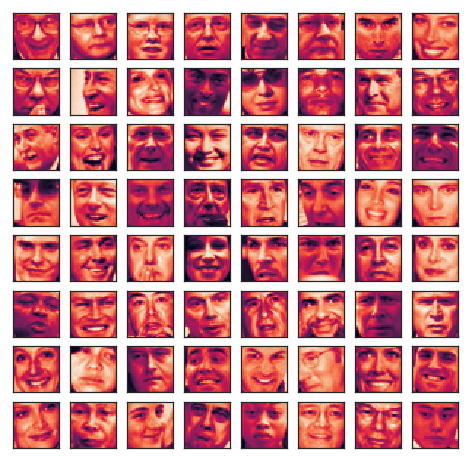

In [76]:
plot_n_image(X, n=64)
plt.show()

In [77]:
U, _, _ = pca(X)
U.shape

(1024, 1024)

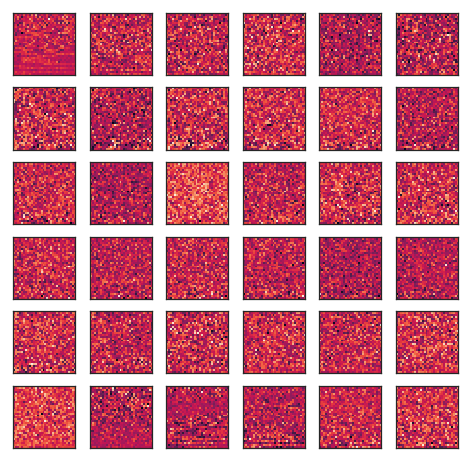

In [78]:
plot_n_image(U, n=36)
plt.show()

<font face=楷体>无人脸出现</font>

## 将维度k降为100

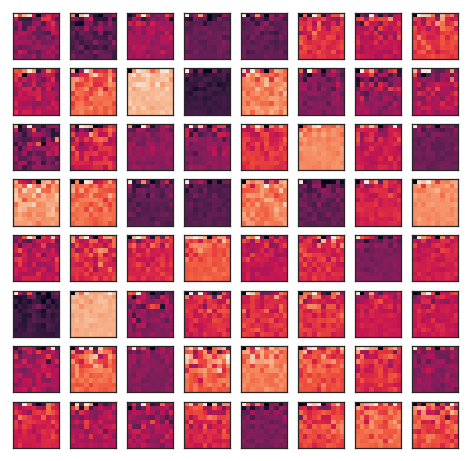

In [79]:
Z = project_data(X, U, k=100)
plot_n_image(Z, n=64)
plt.show()

<font face=楷体>无人脸出现</font>

## 从k = 100恢复

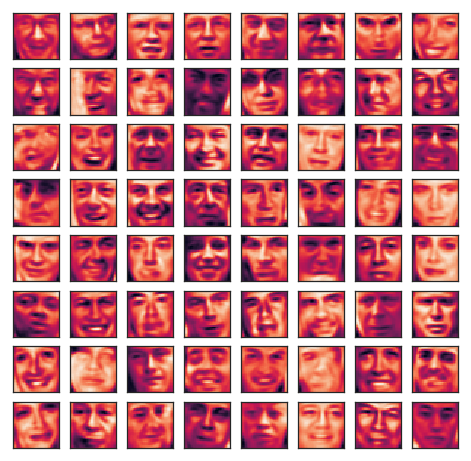

In [80]:
X_recover = recover_data(Z, U)
plot_n_image(X_recover, n=64)
plt.show()


## sklearn PCA

In [81]:
from sklearn.decomposition import PCA

sk_pca = PCA(n_components=100)
Z = sk_pca.fit_transform(X)
Z.shape

(5000, 100)

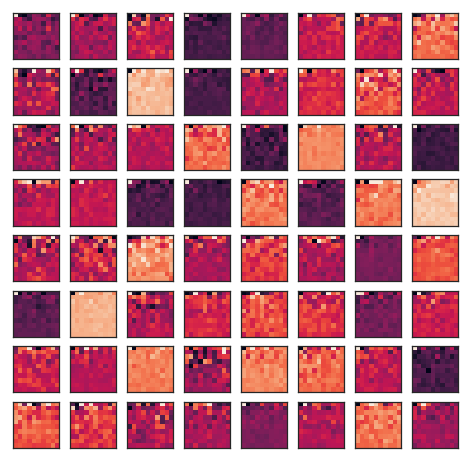

In [82]:
plot_n_image(Z, 64)
plt.show()

In [83]:
X_recover = sk_pca.inverse_transform(Z)
X_recover.shape

(5000, 1024)

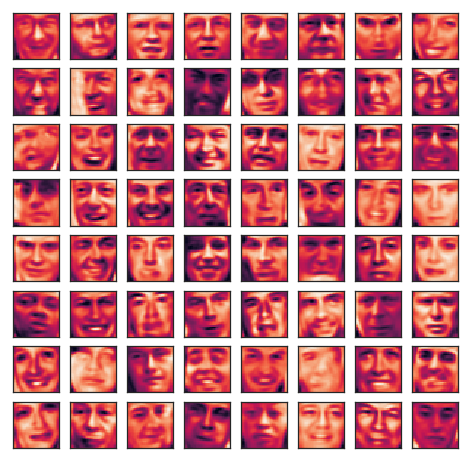

In [84]:
plot_n_image(X_recover, n=64)
plt.show()